1/1 [==============================] - 0s 50ms/step
4


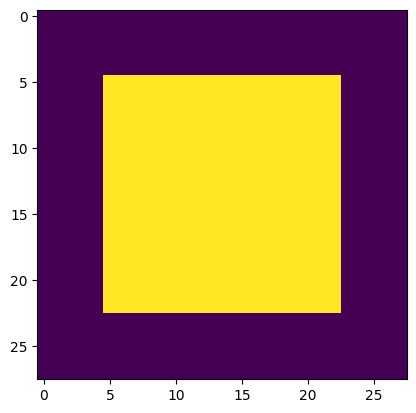

In [2]:
from keras.models import load_model
from tkinter import *
import tkinter as tk
import win32gui
import os
import cv2
from PIL import ImageGrab, Image
import numpy as np
import matplotlib.pyplot as plt

model = load_model('mnist_model.h5')

def get_handle():
    toplist = []
    windows_list = []
    canvas = 0
    def enum_win(hwnd, result):
        win_text = win32gui.GetWindowText(hwnd)
        #print(hwnd, win_text)
        windows_list.append((hwnd, win_text))
    win32gui.EnumWindows(enum_win, toplist)
    for (hwnd, win_text) in windows_list:
        if 'tk' == win_text:
            canvas = hwnd
    return canvas

def preprocessing_image():
    """function to preprocess the image to"""
    image = cv2.imread('test.jpg')
    #print(type(image))
    grey = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(grey.copy(), 75, 255, cv2.THRESH_BINARY_INV)
    # cv2.imshow('binarized image', thresh)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # print(type(contours[0]))
    # print(len(contours[0]))
    cv2.drawContours(image, contours, -1, (0, 255, 0), 3) 
    #cv2.imshow('Contours', image) 
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)        
        # Creating a rectangle around the digit in the original image (for displaying the digits fetched via contours)
        cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)
        # Cropping out the digit from the image corresponding to the current contours in the for loop
        digit = thresh[y:y+h, x:x+w]        
        # Resizing that digit to (18, 18)
        resized_digit = cv2.resize(digit, (18,18))        
        # Padding the digit with 5 pixels of black color (zeros) in each side to finally produce the image of (28, 28)
        padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values=0)        
        # Adding the preprocessed digit to the list of preprocessed digits
        preprocessed_digit = (padded_digit)
    return preprocessed_digit

def predict_digit(img):
    """function to predict the digit. 
    Argument of function is PIL Image"""
    img.save('test.jpg')
    preprocessed_image = preprocessing_image()
    # print(type(preprocessed_image))
    # print(preprocessed_image.shape)
    img = preprocessed_image.reshape(1, 28, 28, 1)
    plt.imshow(img.reshape(28, 28))
    img = img/255.0
    #predicting the digit
    result = model.predict([img])[0]
    os.remove('test.jpg')
    return np.argmax(result), max(result)

class App(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)
        self.x = self.y = 0
        # Creating elements
        self.canvas = tk.Canvas(self, width=300, height=300, bg = "white", cursor="cross")
        self.label = tk.Label(self, text="Thinking..", font=("Helvetica", 48))
        self.classify_btn = tk.Button(self, text = "Recognise", command = self.classify_handwriting) 
        self.button_clear = tk.Button(self, text = "Clear", command = self.clear_all)
        # Grid structure
        self.canvas.grid(row=0, column=0, pady=2, sticky=W, )
        self.label.grid(row=0, column=1,pady=2, padx=2)
        self.classify_btn.grid(row=1, column=1, pady=2, padx=2)
        self.button_clear.grid(row=1, column=0, pady=2)
        #self.canvas.bind("<Motion>", self.start_pos)
        self.canvas.bind("<B1-Motion>", self.draw_lines)
    def clear_all(self):
        self.canvas.delete("all")
    def classify_handwriting(self):
        HWND = self.canvas.winfo_id() # get the handle of the canvas
        hwnd = get_handle()
        rect = win32gui.GetWindowRect(HWND) # get the coordinate of the canvas
        x1, y1, x2, y2 = rect
        # print(x1,x2, y1,y2)
        im = ImageGrab.grab((x1+40, y1+40, x2+100, y2+100))
        digit, acc = predict_digit(im)
        print(digit)
        self.label.configure(text= str(digit)+', '+ str(int(acc*100))+'%')
    def draw_lines(self, event):
        self.x = event.x
        self.y = event.y
        r=8
        self.canvas.create_oval(self.x-r, self.y-r, self.x + r, self.y + r, fill='black')

app = App()
mainloop()